In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [429]:
def get_data():
    xls_file = pd.ExcelFile('R_Python_interview questions_v3.xlsx')
    data = xls_file.parse('data')
    data=data.assign(day=[ int(i.replace('DAY', '')) for i in data.timepoint])
    data.index = data.day
    return data

In [430]:
data = get_data()

subjects = data.subject.unique()
print('subject:', subjects, len(subjects))
days = data.timepoint.unique()
print('day:', days)
markers = data.marker.unique()
print('marker:', markers)
treatments = data.treatment_group.unique()
print('treatment_group:', treatments)

subject: ['A' 'B' 'F' 'L' 'M' 'N' 'P' 'C' 'D' 'E' 'G' 'K' 'J' 'H' 'Q' 'R' 'S' 'T'
 'U' 'V' 'W'] 21
day: ['DAY1' 'DAY15' 'DAY22' 'DAY29' 'DAY8']
marker: ['C4' 'C8' 'TG']
treatment_group: ['TA' 'TB' 'TC']


## Longitudinal plotting: Please construct a graph with timepoints on the x-axis, analyte value on the y-axis. Each subject should be a line. Use shape, color and faceting to represent other aspects of the longitudinal data


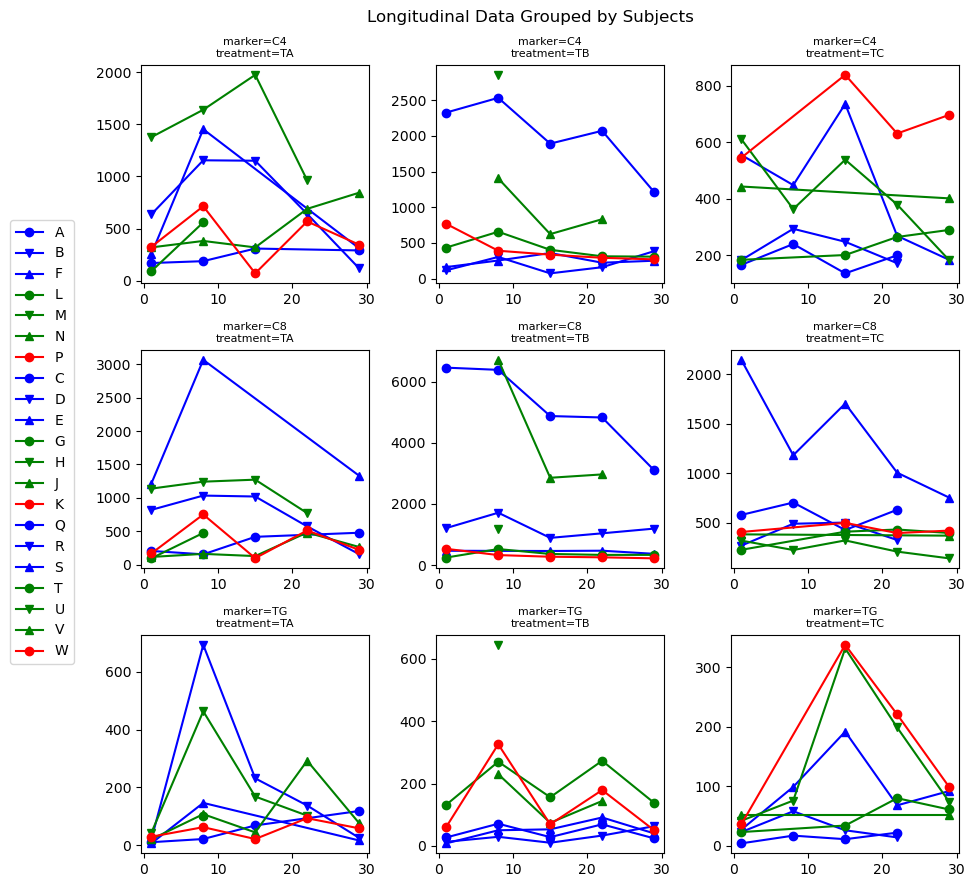

In [431]:
data = get_data()
# config of plotting
fig, ax = plt.subplots(3, 3, figsize=(9,9))
styles = []
for c in 'bgrcmyk':
    styles += [(c, s) for s in 'ov^']
    
# grouping
groups = data.groupby(['marker', 'treatment_group'])
i= 0 
for names, sub_df in groups:
    sub_df.sort_index(inplace=True)
    sub_groups = sub_df[['subject', 'day', 'analyte_value']].groupby(['subject'])
    # print(names, sub_df)

    # plot
    x,y = int(i/3), i%3
    n=0
    for subject, df3 in sub_groups:
        style = styles[n]
        ax[x, y].plot(df3.day, df3.analyte_value, color=style[0], marker=style[1], label=subject[0])
        n+=1
    ax[x, y].set_title(f"marker={names[0]}\ntreatment={names[1]}", fontsize=8)
    i+=1
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:21], labels[:21], loc='outside right', ncol=1, bbox_to_anchor=(0, .5))
fig.suptitle("Longitudinal Data Grouped by Subjects")
plt.tight_layout()
plt.show()

## 2. Please provide a version of the above graph as Mean ± SD with each treatment group’s mean connected by a line, and a unique shape and color for each treatment group. The objective is to understand how the mean analyte value for each group changes with treatment. Use various features of the graphs to highlight different aspects

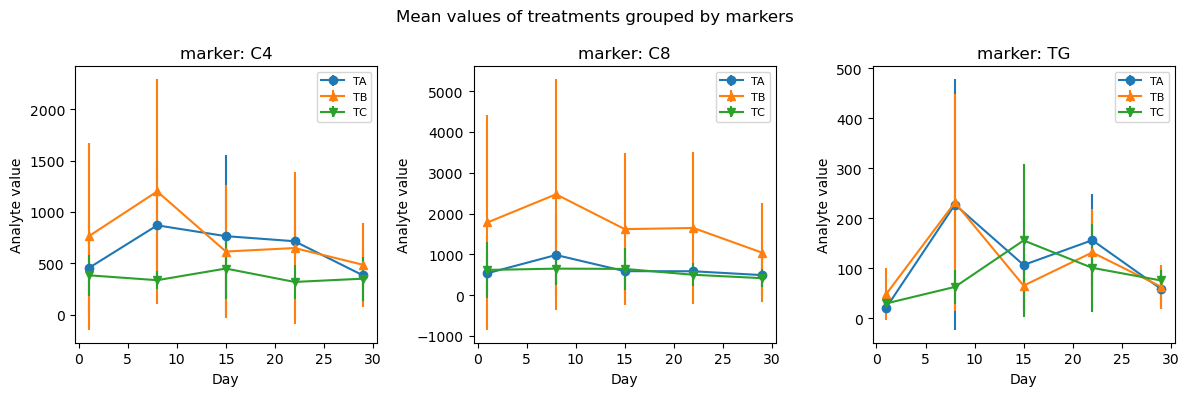

In [432]:
data = get_data()

fig, ax = plt.subplots(1, 3, figsize=(12,4))
markers = 'o^v'
n=0
groups1 = data.groupby(['marker'])
for marker, df1 in groups1:
    groups2 = df1.groupby(['treatment_group'])
    m=0
    for treatment, sub_df in groups2:
        df2 = sub_df[['analyte_value']].groupby(['day']).agg(['mean', 'std'])['analyte_value']
        ax[n].errorbar(df2.index, df2['mean'], yerr=df2['std'], marker=markers[m], label=treatment[0])
        ax[n].legend(fontsize=8)
        m+=1
    ax[n].set_title(f"marker: {marker[0]}")
    ax[n].set_xlabel("Day")
    ax[n].set_ylabel("Analyte value")
    n+=1
fig.suptitle("Mean values of treatments grouped by markers")
plt.tight_layout()
plt.show()

## 3. Please convert the input data table to another table in which each timepoint become a separate column filled with corresponding analyte values and other columns remain

In [433]:
data = get_data()

days = data.timepoint.unique()
print(days)
for day in days:
    data[day] = [0]*data.shape[0]
    data.loc[data['timepoint']==day, day] = data.loc[data['timepoint']==day, 'analyte_value']
data

['DAY1' 'DAY15' 'DAY22' 'DAY29' 'DAY8']


,subject,timepoint,analyte_value,marker,treatment_group,day,DAY1,DAY15,DAY22,DAY29,DAY8
day,,,,,,,,,,,
1,A,DAY1,169,C4,TA,1,169,0,0,0,0
1,A,DAY1,207,C8,TA,1,207,0,0,0,0
1,A,DAY1,10,TG,TA,1,10,0,0,0,0
1,B,DAY1,636,C4,TA,1,636,0,0,0,0
1,B,DAY1,821,C8,TA,1,821,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8,S,DAY8,1181,C8,TC,8,0,0,0,0,1181
8,S,DAY8,99,TG,TC,8,0,0,0,0,99
8,U,DAY8,363,C4,TC,8,0,0,0,0,363


## 4. Please test for each marker whether Day 8 and Day 1 readouts are different at alpha = 0.05 under each treatment

given treatment, and marker
H0: mean of day1 = mean of day8
H1: different
Do t-test and get 95% confidence interval (alpha=0.05) of this population. Accept H0 if mean of day1 and day8 falls into the CI, otherwise reject H0.

In [434]:
from scipy import stats

data = get_data()

# normalization
data['z'] = (data.analyte_value - np.mean(data.analyte_value))/np.std(data.analyte_value)

print('treatment\tmarker\tp value\t\tmean of day1\tmean of day8\t\t95% CI')
g1 = data.groupby(['treatment_group', 'marker'])
for (treatment, marker), df1 in g1:
    day1 = df1.loc[df1.day==1, 'z']
    mean_day1 = np.mean(day1)
    day8 = df1.loc[df1.day==8, 'z']
    mean_day8 = np.mean(day8)
   
    t_res = stats.ttest_ind(day1, day8)
    p = t_res.pvalue
    ci= t_res.confidence_interval(0.05)
    ci = f"{ci.low:4f}-{ci.high:4f}"
    print(f"{treatment}\t\t{marker}\t{p:4f}\t{mean_day1:1f}\t{mean_day8:1f}\t{ci}")


treatment	marker	p value		mean of day1	mean of day8		95% CI
TA		C4	0.145432	-0.123130	0.317237	-0.458477--0.422258
TA		C8	0.313798	-0.033699	0.438037	-0.500465--0.443006
TA		TG	0.071400	-0.578880	-0.360958	-0.224929--0.210914
TB		C4	0.482928	0.203375	0.665912	-0.503351--0.421721
TB		C8	0.677524	1.279108	2.007976	-0.838293--0.619443
TB		TG	0.096552	-0.550165	-0.356585	-0.200368--0.186794
TC		C4	0.667346	-0.196273	-0.246606	0.043028-0.057638
TC		C8	0.935053	0.051660	0.085140	-0.059241--0.007719
TC		TG	0.052092	-0.569982	-0.535069	-0.035919--0.033906


## 5. Please fit an approriate statistical model for each marker with analyte_value as dependent variables, and timepoint and treatment as independent variables (both are conisidered factors). Assume subjects are randomly drawn from a population. With each model, please report the significance of treatment effect and the contrast between Day 22 and Day 8

analyte_value ~ timepoint + treatment

In [444]:
from sklearn.linear_model import LinearRegression

data = get_data()
g1 = data.groupby(['marker'])

markers = data['marker'].unique()
intercept = pd.Series(np.zeros(len(markers)), index=markers)
coef = pd.DataFrame(np.zeros((6, len(markers))), columns=markers)
for marker, df1 in g1:
    model = LinearRegression()
    X = pd.get_dummies(data=df1[['timepoint','treatment_group']], drop_first=True)
    Y = df1['analyte_value']
    model.fit(X, Y)
    # 
    intercept[marker[0]] = model.intercept_
    coef[marker[0]] = list(model.coef_)
    pred = model.predict(X)
    # print(df1)
coef.index = X.columns
print(f"Intercept:\n{intercept}")
print(f"Coefficient:\n{coef}")

Intercept:
C4    562.188686
C8    616.147197
TG     42.164862
dtype: float64
Coefficient:
                            C4           C8          TG
timepoint_DAY15      76.744599   -23.383582   76.889589
timepoint_DAY22      20.365429   -67.023356   94.455492
timepoint_DAY29    -119.940584  -323.470449   32.886564
timepoint_DAY8      320.462141   449.177437  157.406569
treatment_group_TB  127.287443  1108.492521   -5.556217
treatment_group_TC -236.431751   -36.322764  -22.598062


In [447]:
from scipy import stats
confidence = .95
squared_err = (pred-Y)**2
np.sqrt(stats.t.interval(confidence, len(squared_err)-1, loc=squared_err.mean(), scale=stats.sem(squared_err) ))

array([ 71.20008711, 143.14767761])

for marker C4, analyte value increase with the increase of treatment day8-22, but the effect decrease with the increase of the days. Analyte value decrease with the increase od timepoint after day29. treatment TB and TC has possitive and negative effect on C4, respectively. Among timepoints and treatments, day8 has the most effect on analyte value. The cofficient reveals on day8 and day22, the average analyte value is expected to increase by 320, and 20.

for marker C8, analyte value decrease with the increase of treatment time except day 8. Longer treatment time have more negative effect on analyte value. The cofficient reveals on day8 and day22, the average analyte value is expected to increase by 4490, and decrease by 67.  treatment TB and TC has possitive and negative effect on C8, respectively. In treatment TB, the average analyte value is expected to increase by 1108.

for marker TG, analyte value inrease with the increase of treatment time. The cofficient reveals on day8 and day22, the average analyte value is expected to increase by 157, and 94. Both treatment TB and TC has negative effect on TG. for the treatment TB or TC, the average analyte value is expected to decrease 5 and 22.

In ssuumary on day 8 and treatment TB, the average values of C4, C8, and TG are expected to increase 320+127, 449+1108, and 157-5.

Considering the intercepts, the expected values of C4, C8 and TG are 562, 626, and 42 when the categorical variables timepoint and treatment are not considered (they are zeros). That indicates: 1. The baseline of analyte value of C4 and C8 are higher than that of TG. 2. other independent variables should be considered for C4 and C8.

In [464]:
# NOTE: The code is borrowed from https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
def get_CI(alpha, lr, X, y):
    """
    Returns (1-alpha) 2-sided confidence intervals
    for sklearn.LinearRegression coefficients
    """
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, 'const', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'lower': coefs - gap, 'upper': coefs + gap
    }, index=X_aux.columns)

alpha = 0.05
get_CI(alpha, model, X.astype(int), Y)

,lower,upper
const,-24.484390,108.814114
timepoint_DAY15,-2.732671,156.511850
timepoint_DAY22,13.466837,175.444148
timepoint_DAY29,-49.386385,115.159514
timepoint_DAY8,78.485599,236.327540
treatment_group_TB,-68.616289,57.503855
treatment_group_TC,-86.511277,41.315154


for treatment TB and TC, the 95% CI are -68 to 57 and -86 to 41 , of which the two span zero. it is likely the treatment TB and TC are coincidence of random variables. for day 8 and day22, the 95% CI are 78-236 and 13-175,  which are positive far from zero. it is likely to reject H0 hypothesis. Therefore, day8 and day22 are statistical signficant. 

## 6. If you had to analyze 1 million markers, how would you parallelize the tests from question 4 on a multi-processor machine? Please demonstrate this parallelization using just the markers available in the spreadsheet

Note: t-test function of question4 is put in the script ttest.py 

In [436]:
from multiprocessing import Pool
from ttest import task

if __name__ == "__main__":
    data = get_data()
    g1 = data.groupby(['treatment_group', 'marker'])

    # multi processes
    p = Pool(processes=3)
    output = p.map(task, [df1 for marker, df1 in g1])
    print(output)

[{'CI': '-434.297301--399.988413', 'pvalue': 0.14543238785926918}, {'CI': '-474.071557--419.642729', 'pvalue': 0.3137976094622906}, {'CI': '-213.066240--199.790903', 'pvalue': 0.07139999904776864}, {'CI': '-476.805537--399.480177', 'pvalue': 0.4829275034728284}, {'CI': '-794.083015--586.774128', 'pvalue': 0.6775240811067171}, {'CI': '-189.800470--176.942387', 'pvalue': 0.09655234408148136}, {'CI': '40.758803-54.598340', 'pvalue': 0.6673463095707332}, {'CI': '-56.116786--7.311786', 'pvalue': 0.9350527882168845}, {'CI': '-34.024611--32.118246', 'pvalue': 0.0520915355627469}]


## 7. Please automate the table view for different layouts, i.e., write a function that takes the input data and another parameter indicating a categorical (nominal) variable so that the output of this function will produce a new table in which each level of the indicated variable become a separate column filled with corresponding analyte_value and others columns remain. In the data provided for the quiz, except "analyte_value", all other variables are factors

In [415]:
data = get_data()
data

,subject,timepoint,analyte_value,marker,treatment_group,day
day,,,,,,
1,A,DAY1,169,C4,TA,1
1,A,DAY1,207,C8,TA,1
1,A,DAY1,10,TG,TA,1
1,B,DAY1,636,C4,TA,1
1,B,DAY1,821,C8,TA,1
...,...,...,...,...,...,...
8,S,DAY8,1181,C8,TC,8
8,S,DAY8,99,TG,TC,8
8,U,DAY8,363,C4,TC,8


In [437]:
from copy import deepcopy

def func(data, _var):
    data = deepcopy(data)
    values = data[_var].unique()
    for val in values:
        data[val] = [0]*data.shape[0]
        data.loc[data[_var]==val, val] = data.loc[data[_var]==val, 'analyte_value']
    return data
# 
data = get_data()
func(data, 'timepoint')

,subject,timepoint,analyte_value,marker,treatment_group,day,DAY1,DAY15,DAY22,DAY29,DAY8
day,,,,,,,,,,,
1,A,DAY1,169,C4,TA,1,169,0,0,0,0
1,A,DAY1,207,C8,TA,1,207,0,0,0,0
1,A,DAY1,10,TG,TA,1,10,0,0,0,0
1,B,DAY1,636,C4,TA,1,636,0,0,0,0
1,B,DAY1,821,C8,TA,1,821,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8,S,DAY8,1181,C8,TC,8,0,0,0,0,1181
8,S,DAY8,99,TG,TC,8,0,0,0,0,99
8,U,DAY8,363,C4,TC,8,0,0,0,0,363


In [438]:
func(data, 'marker')

,subject,timepoint,analyte_value,marker,treatment_group,day,C4,C8,TG
day,,,,,,,,,
1,A,DAY1,169,C4,TA,1,169,0,0
1,A,DAY1,207,C8,TA,1,0,207,0
1,A,DAY1,10,TG,TA,1,0,0,10
1,B,DAY1,636,C4,TA,1,636,0,0
1,B,DAY1,821,C8,TA,1,0,821,0
...,...,...,...,...,...,...,...,...,...
8,S,DAY8,1181,C8,TC,8,0,1181,0
8,S,DAY8,99,TG,TC,8,0,0,99
8,U,DAY8,363,C4,TC,8,363,0,0


In [439]:
func(data, 'treatment_group')

,subject,timepoint,analyte_value,marker,treatment_group,day,TA,TB,TC
day,,,,,,,,,
1,A,DAY1,169,C4,TA,1,169,0,0
1,A,DAY1,207,C8,TA,1,207,0,0
1,A,DAY1,10,TG,TA,1,10,0,0
1,B,DAY1,636,C4,TA,1,636,0,0
1,B,DAY1,821,C8,TA,1,821,0,0
...,...,...,...,...,...,...,...,...,...
8,S,DAY8,1181,C8,TC,8,0,0,1181
8,S,DAY8,99,TG,TC,8,0,0,99
8,U,DAY8,363,C4,TC,8,0,0,363
